In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

from utils.visualize import *
from utils.FIR_filter import *
from utils.signal_process import *

# Align IMU

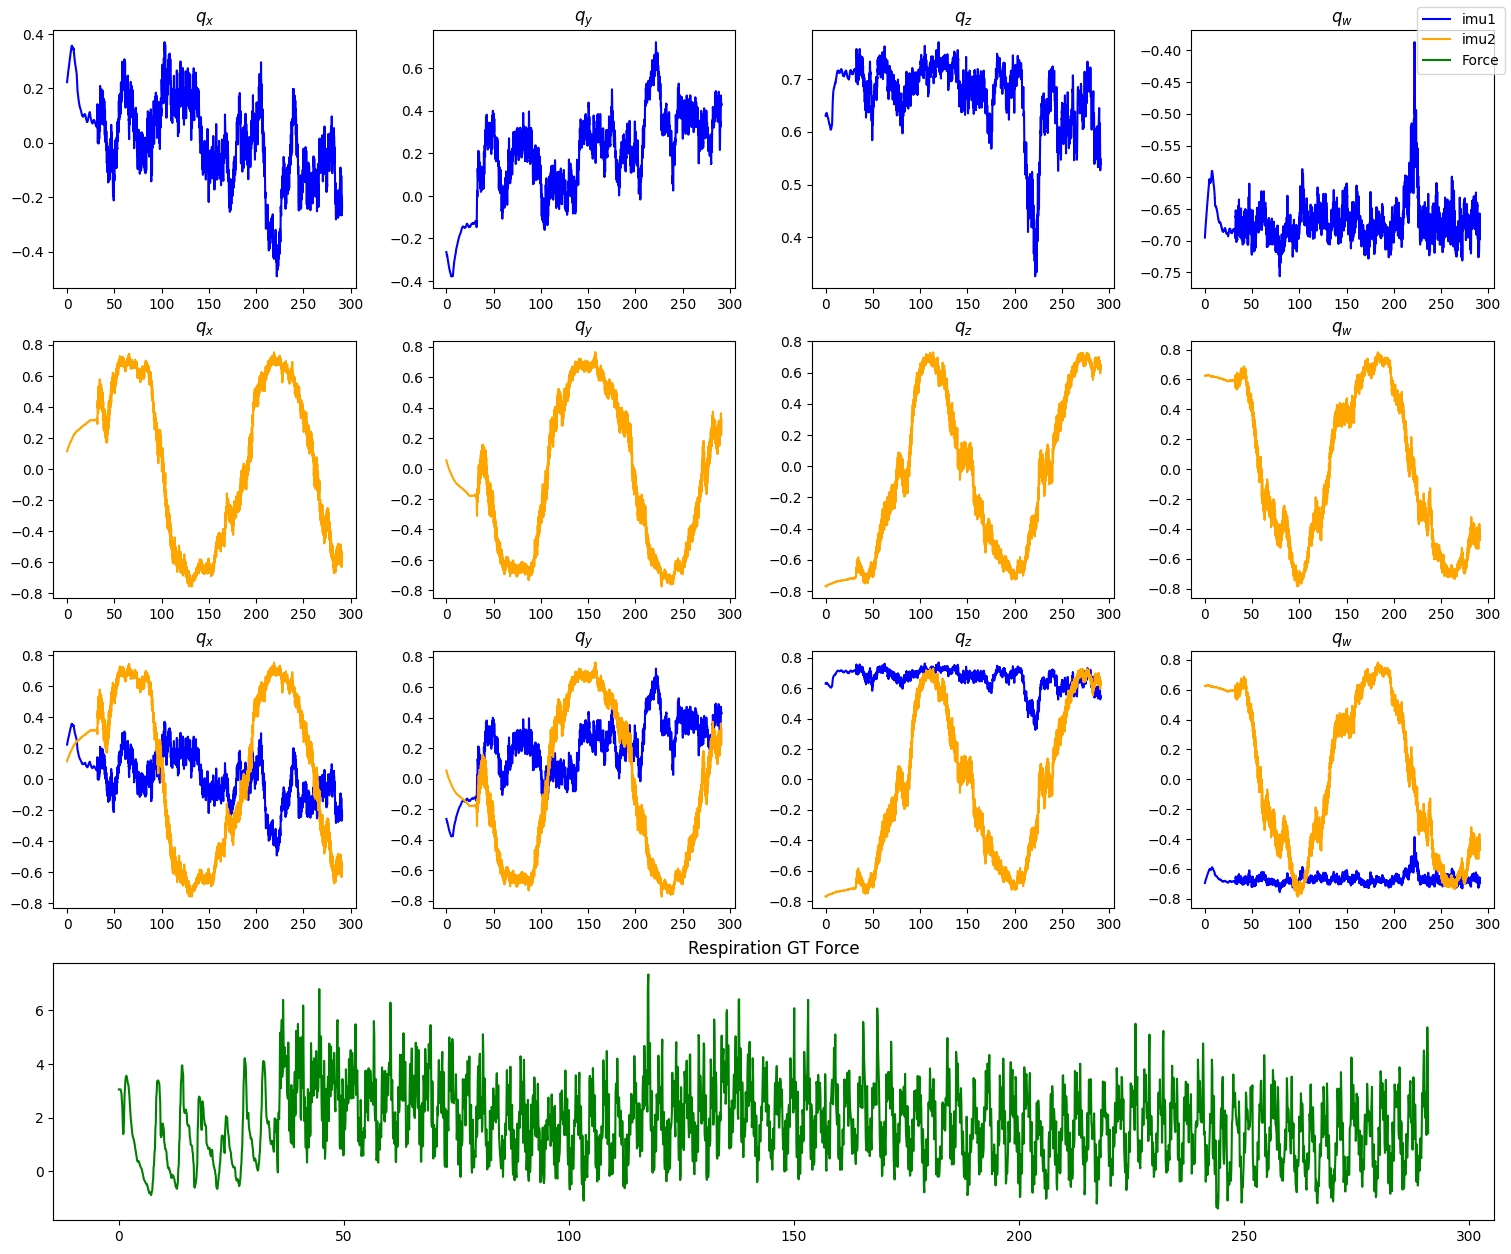

In [2]:
fs = 10
start_pt, end_pt = 0, -1
still_pt = 300 # 500

action_name = "run_stand_5"
# sit_3, stand_3, walk_stand_3, run_stand_3
# sit_5, stand_5, walk_stand_5, run_stand_5, mix_3
file_path = f'./data/hamham/test/{action_name}.csv'


data = pd.read_csv(file_path)
data.columns = [
    "Timestamp",
    "imu1_q_x",
    "imu1_q_y",
    "imu1_q_z",
    "imu1_q_w",
    "imu2_q_x",
    "imu2_q_y",
    "imu2_q_z",
    "imu2_q_w",
    "Force",
    "RR",
]
sensor_names=['imu1','imu2']
cols = ['q_x', 'q_y', 'q_z', 'q_w']
data = data.iloc[start_pt:end_pt]

data = align_delay(data, delay=10)
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.set_index("Timestamp")

draw_imu_curve(data, overlap=True, show_gt=True)
# draw_imu_curve(data, overlap=True, show_gt=False)

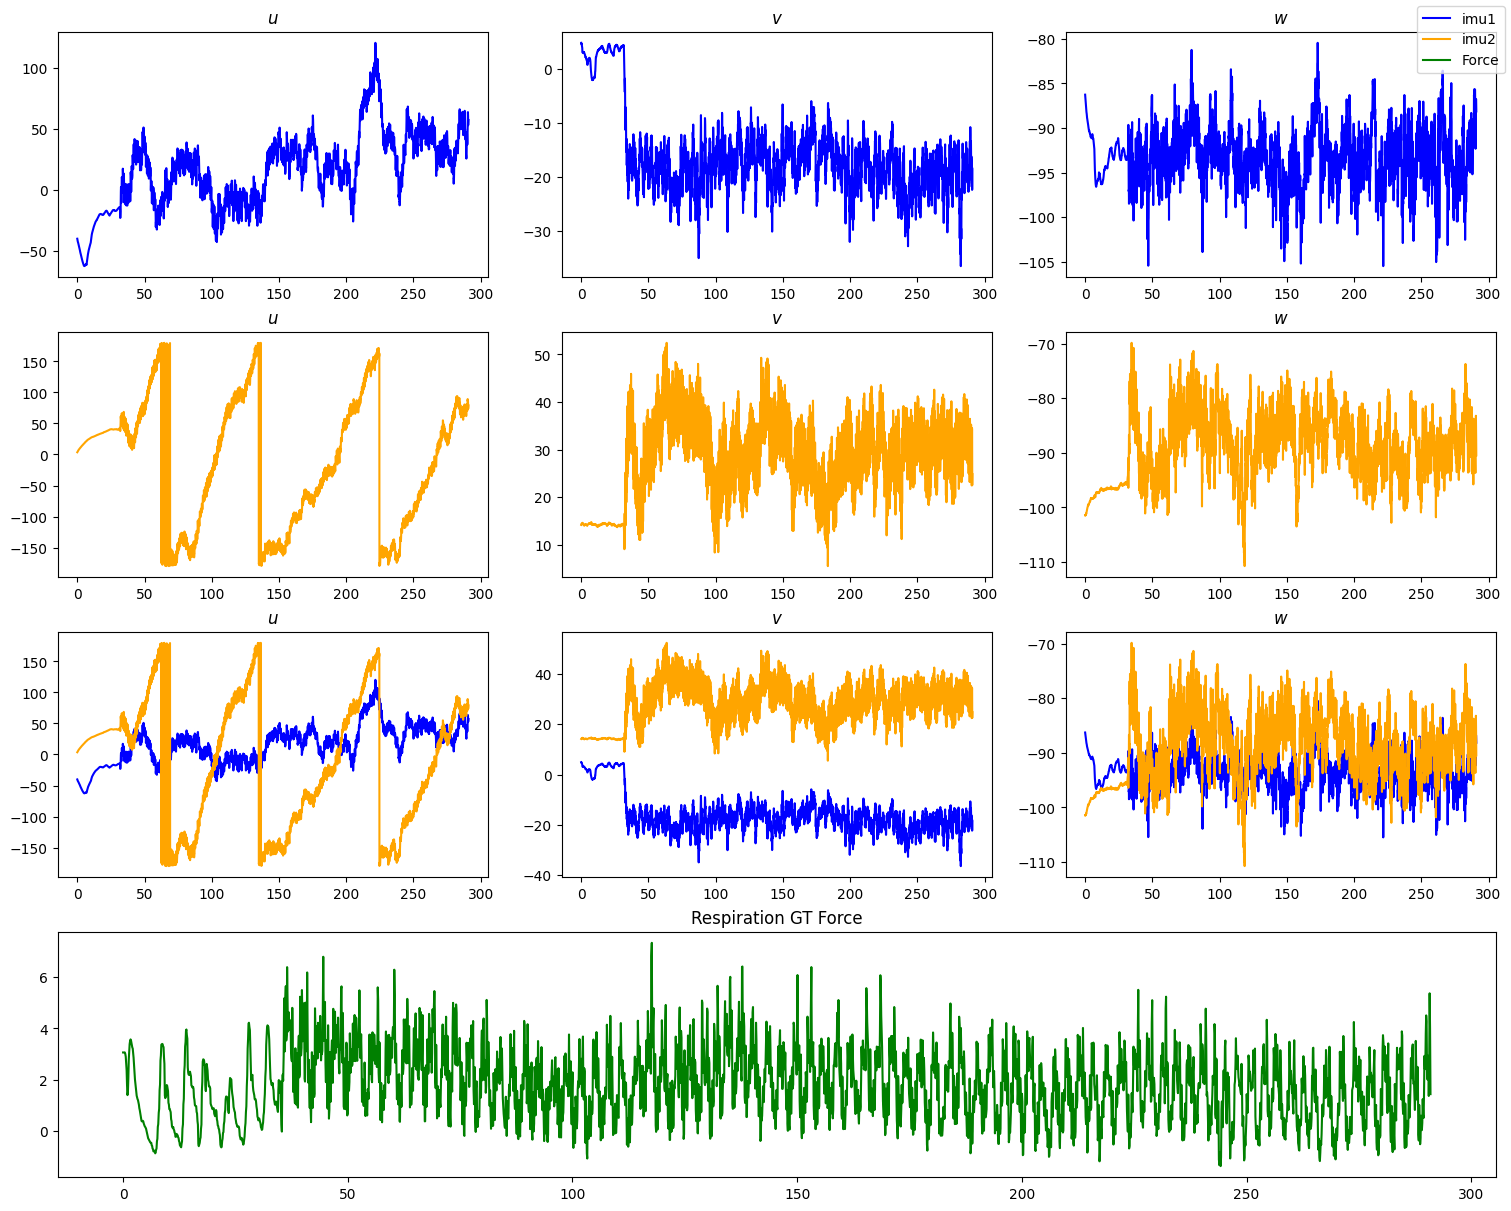

In [3]:
euler_axes = ['u', 'v', 'w']
euler_angles = {}
for imu in sensor_names:
    q = data[[imu + "_" + "q_x", imu + "_" + "q_y", imu + "_" + "q_z", imu + "_" + "q_w"]].values
    u, v, w = quaternion_to_euler(q)
    euler_angle = [u, v, w]
    # euler_angle = [u - np.mean(u), v - np.mean(v), w - np.mean(w)]
    for i, euler_axis in enumerate(euler_axes):
        euler_angles[imu + "_" + euler_axis] = euler_angle[i]

draw_imu_curve_euler(data, euler_angles, overlap=True, show_gt=True)
# draw_imu_curve_euler(data, euler_angles, overlap=True, show_gt=False)

In [4]:
q_corr = Q_RANSAC(data[0:still_pt], pool=1.0, d=0.05)

best_score/total: 134/300


In [5]:
target, skew = 'imu1', 'imu2'
Q_skew = data[[skew + '_q_x', skew + '_q_y', skew + '_q_z', skew + '_q_w']].to_numpy()
Q_aligned = align_quaternion(q_corr, Q_skew) # (sample num, 4)
data_aligned = data.copy()

for i, col in enumerate(cols):
    data_aligned[[skew + '_' + col]] = Q_aligned[:, i].reshape(-1, 1)

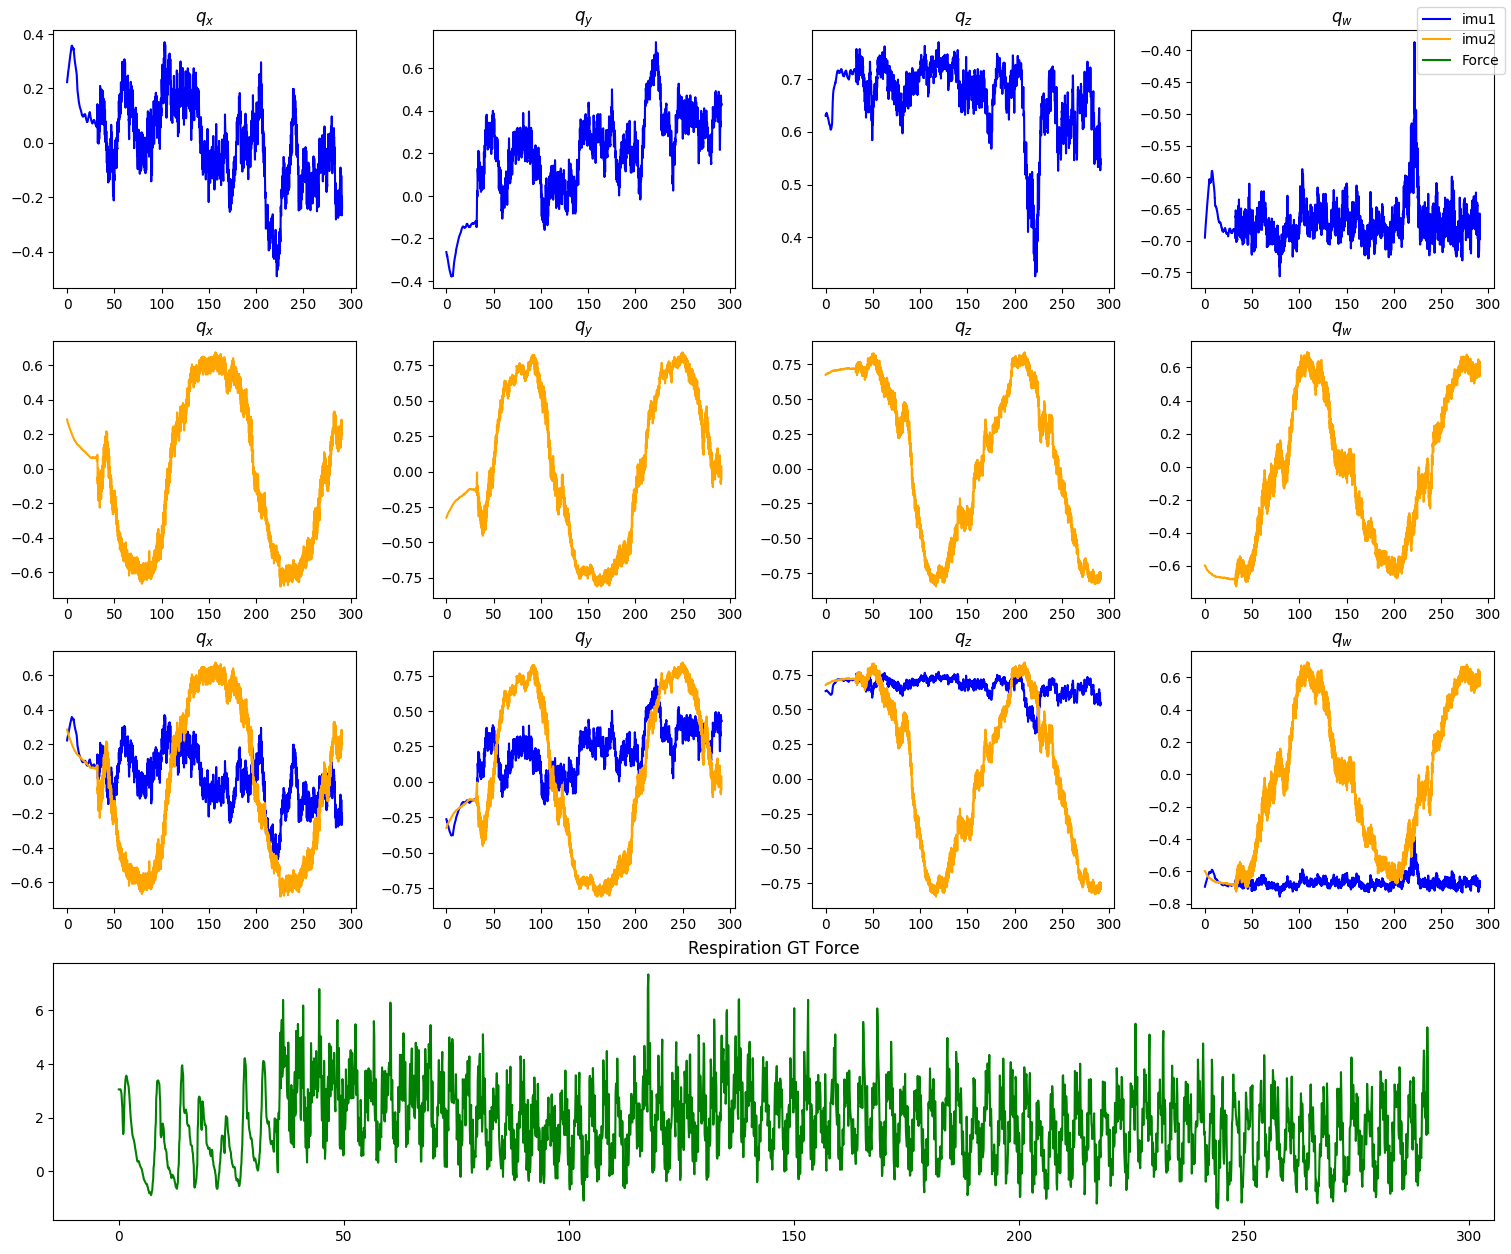

In [6]:
draw_imu_curve(data_aligned, overlap=True, show_gt=True)
# draw_imu_curve(data_aligned, overlap=True, show_gt=False)

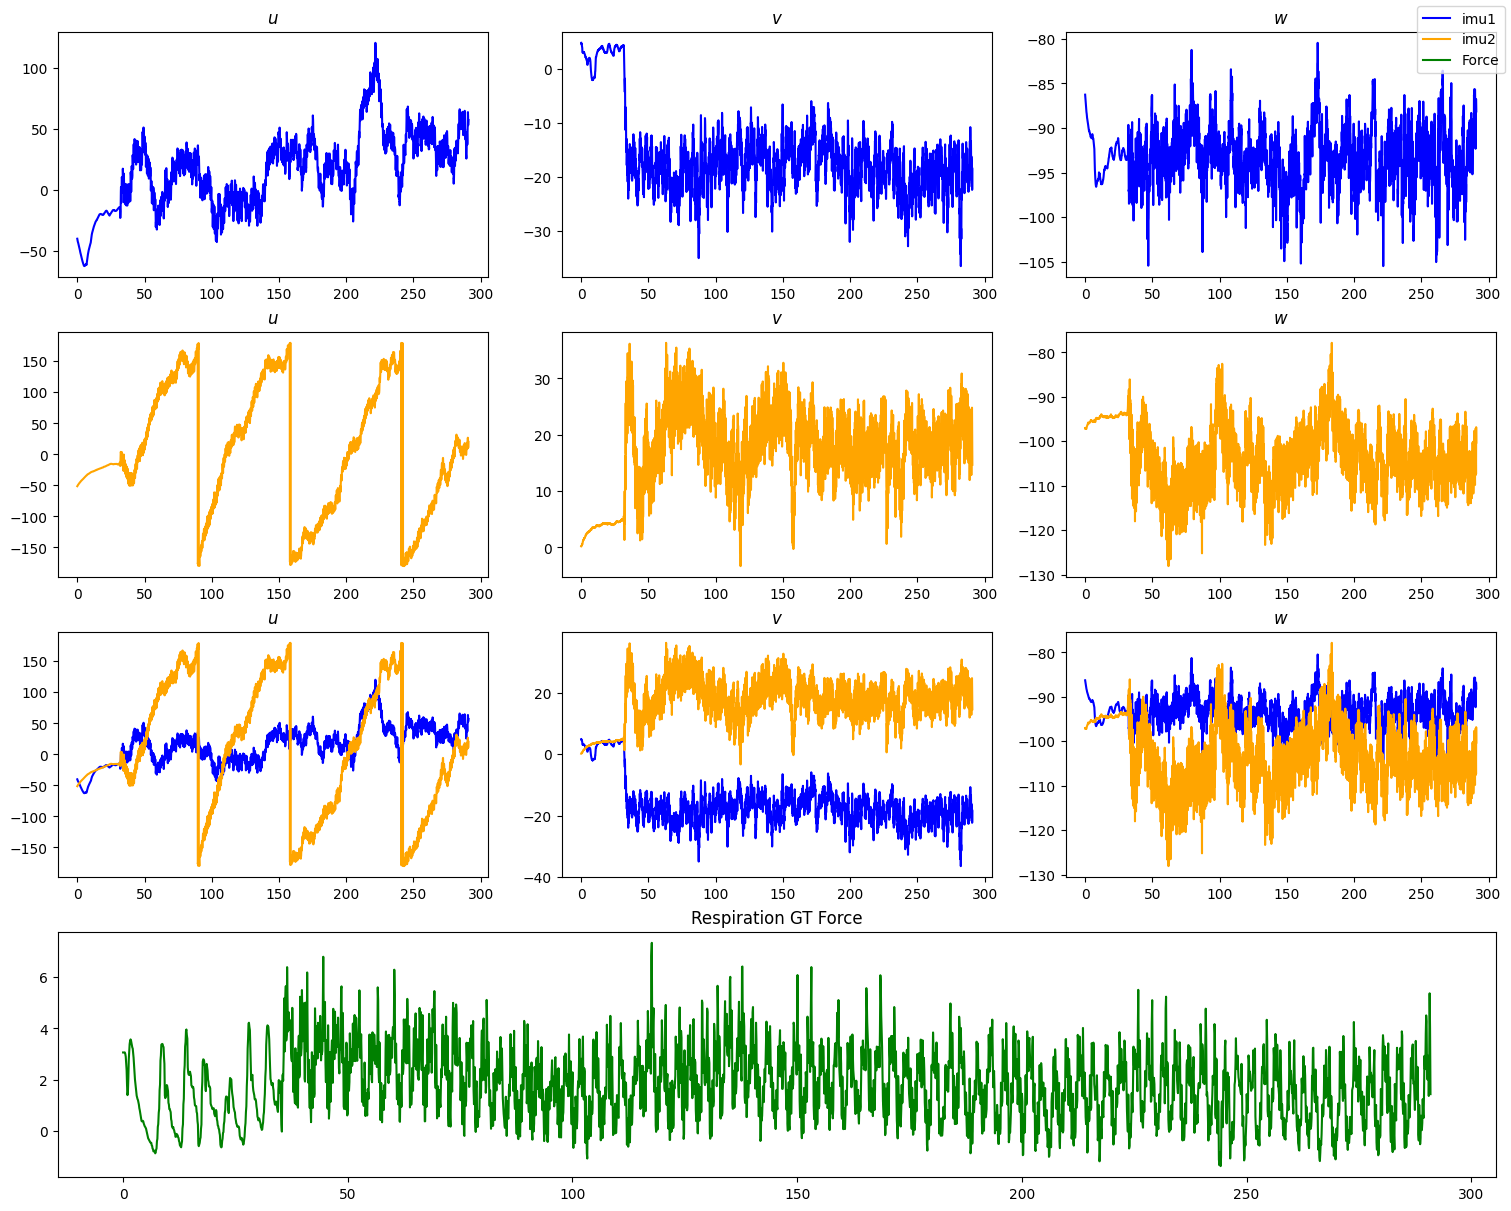

In [7]:
euler_axes = ['u', 'v', 'w']
euler_angles = {}
for imu in sensor_names:
    q = data_aligned[[imu + "_" + "q_x", imu + "_" + "q_y", imu + "_" + "q_z", imu + "_" + "q_w"]].values
    u, v, w = quaternion_to_euler(q)
    euler_angle = [u, v, w]
    # euler_angle = [u - np.mean(u), v - np.mean(v), w - np.mean(w)]
    for i, euler_axis in enumerate(euler_axes):
        euler_angles[imu + "_" + euler_axis] = euler_angle[i]

draw_imu_curve_euler(data_aligned, euler_angles, overlap=True, show_gt=True)
# draw_imu_curve_euler(data_aligned, euler_angles, overlap=True, show_gt=False)

# ANC

In [8]:
data_anc = data_aligned # data used in anc
data_anc = data_anc[still_pt+0:]
cols = ['q_x', 'q_y', 'q_z', 'q_w'] # for quaternion
# cols = ['u', 'v', 'w'] # for euler angle

# data_anc.loc[:, "Force"] = butter_filter(data_anc["Force"], cutoff=0.66)

In [9]:
# Parameters
# Common
NTAPS = 10 # 10
LEARNING_RATE = 0.005 # 0.001

# RLS
delta = 1 # 1
lam_rls = 0.998 # 0.9995, 0.998

# LRLS
epsilon = 1e-6
lam_lrls = 0.998 # 0.9995

In [10]:
# Init
outputs_dict_LMS = {}
outputs_dict_LMS['method'] = 'LMS'
coefficients_dict_LMS = {}
coefficients_dict_LMS['method'] = 'LMS'

outputs_dict_LMSLS = {}
outputs_dict_LMSLS['method'] = 'LMS+LS'
coefficients_dict_LMSLS = {}
coefficients_dict_LMSLS['method'] = 'LMS+LS'

outputs_dict_RLS = {}
outputs_dict_RLS['method'] = 'RLS'
coefficients_dict_RLS = {}
coefficients_dict_RLS['method'] = 'RLS'

outputs_dict_LRLS = {}
outputs_dict_LRLS['method'] = 'LRLS'
coefficients_dict_LRLS = {}
coefficients_dict_LRLS['method'] = 'LRLS'

In [11]:
# LMS
def LMS():
    for col in cols:
        d = data_anc[sensor_names[0] + '_' + col].to_numpy() # IMU1 (desire signal with more RR info.)
        x = data_anc[sensor_names[1] + '_' + col].to_numpy() # IMU2 (reference noise)
        f = FIR_filter(np.zeros(NTAPS))
        y = np.empty(len(d))

        coefficients_history = np.empty((len(d), NTAPS))
        
        # DO FIR filter
        for i in range((len(d))):
            ref_noise = x[i]
            canceller = f.filter(ref_noise)
            output_signal = d[i] - canceller
            f.lms(output_signal, LEARNING_RATE)
            coefficients_history[i] = f.coefficients
            y[i] = output_signal
        
        outputs_dict_LMS[col] = y
        coefficients_dict_LMS[col] = coefficients_history

    # draw_anc_curve(data_anc, outputs=outputs_dict_LMS)
    # draw_fir_coefficients_curve(data_anc, coefficients=coefficients_dict_LMS)

In [12]:
# LMS+LS
def LMSLS():
    for col in cols:
        d = data_anc[sensor_names[0] + '_' + col].to_numpy() # IMU1 (desire signal with more RR info.)
        x = data_anc[sensor_names[1] + '_' + col].to_numpy() # IMU2 (reference noise)
        f = FIR_filter(np.zeros(NTAPS))
        y = np.empty(len(d))

        coefficients_history = np.empty((len(d), NTAPS))

        # Least Square Once
        f.ls(x, d)
        LEARNING_RATE = np.max(f.coefficients) / 100 # / 100
        # print(f'LEARNING_RATE:{LEARNING_RATE}')
        
        # DO FIR filter
        for i in range((len(d))):
            ref_noise = x[i]
            canceller = f.filter(ref_noise)
            output_signal = d[i] - canceller
            f.lms(output_signal, LEARNING_RATE)
            coefficients_history[i] = f.coefficients
            y[i] = output_signal
        
        outputs_dict_LMSLS[col] = y
        coefficients_dict_LMSLS[col] = coefficients_history

    # draw_anc_curve(data_anc, outputs=outputs_dict_LMSLS)
    # draw_fir_coefficients_curve(data_anc, coefficients=coefficients_dict_LMSLS)

In [13]:
# RLS
def RLS():
    for col in cols:
        d = data_anc[sensor_names[0] + '_' + col].to_numpy() # IMU1 (desire signal with more RR info.)
        x = data_anc[sensor_names[1] + '_' + col].to_numpy() # IMU2 (reference noise)
        f = FIR_filter(np.zeros(NTAPS))
        y = np.empty(len(d))

        coefficients_history = np.empty((len(d), NTAPS))
        
        # DO FIR filter
        for i in range((len(d))):
            ref_noise = x[i]
            canceller = f.filter(ref_noise)
            output_signal = d[i] - canceller
            f.rls(output_signal, delta=delta, lam=lam_rls)
            coefficients_history[i] = f.coefficients
            y[i] = output_signal
        
        outputs_dict_RLS[col] = y
        coefficients_dict_RLS[col] = coefficients_history

    # draw_anc_curve(data_anc, outputs=outputs_dict_RLS)
    # draw_fir_coefficients_curve(data_anc, coefficients=coefficients_dict_RLS)

In [14]:
# LRLS
def LRLS():
    for col in cols:
        d = data_anc[sensor_names[0] + '_' + col].to_numpy() # IMU1 (desire signal with more RR info.)
        x = data_anc[sensor_names[1] + '_' + col].to_numpy() # IMU2 (reference noise)
        f = FIR_filter(np.zeros(NTAPS))
        y = np.empty(len(d))

        coefficients_history = np.empty((len(d), NTAPS))
        
        # DO FIR filter
        for i in range((len(d))):
            ref_noise = x[i]
            output_signal = f.lrls(x=ref_noise, d=d[i], N= len(d), lam=lam_lrls)
            coefficients_history[i] = f.coefficients
            y[i] = output_signal
        
        outputs_dict_LRLS[col] = y
        coefficients_dict_LRLS[col] = coefficients_history

    # draw_anc_curve(data_anc, outputs=outputs_dict_LRLS)
    # draw_fir_coefficients_curve(data_anc, coefficients=coefficients_dict_LRLS)

# Test Parameters

In [15]:
# Define parameter ranges
ntaps_values = list(range(10, 51, 20))  # [10, 30, 50]
learning_rate_values = np.arange(0.0005, 0.0021, 0.0005)  # [0.0005, 0.001, 0.0015, 0.002]
delta_values = np.arange(0.5, 2, 0.5)  # [0.5, 1, 1.5]
lam_rls_values = np.arange(0.98, 1.001, 0.005)  # [0.98, 0.985, 0.99, 0.995]
lam_lrls_values = np.arange(0.99, 0.9991, 0.003)  # [0.99, 0.993, 0.996, 0.999]

# Store the best result
best_mae = float('inf')
best_params = {}
best_method = None  # Track the method with the best MAE

# Test all parameter combinations
for ntaps, lr, delta, lam_rls, lam_lrls in itertools.product(
    ntaps_values, learning_rate_values, delta_values, lam_rls_values, lam_lrls_values
):
    # Set current parameters
    NTAPS = ntaps
    LEARNING_RATE = lr
    delta = delta
    lam_rls = lam_rls
    lam_lrls = lam_lrls

    LMS()
    LMSLS()
    RLS()
    LRLS()

    # Auto Correlation
    window = 12.8
    overlap = 6.4
    mae = auto_correlation(
        data_anc,
        outputs=[outputs_dict_LMS, outputs_dict_LMSLS, outputs_dict_RLS, outputs_dict_LRLS],
        window=window,
        overlap=overlap,
        visualize=False
    )

    # Find method with lowest MAE
    min_method = min(mae, key=mae.get)
    min_mae = mae[min_method]

    # Update best result
    if min_mae < best_mae:
        best_mae = min_mae
        best_method = min_method
        best_params = {
            "NTAPS": NTAPS,
            "LEARNING_RATE": LEARNING_RATE,
            "delta": delta,
            "lam_rls": lam_rls,
            "lam_lrls": lam_lrls
        }

    print(f"Params: NTAPS = {NTAPS}, LR = {LEARNING_RATE}, delta = {delta}, lam_rls = {lam_rls}, lam_lrls = {lam_lrls} -> All MAE = {mae}, Best Method = {min_method}")

print("---------------------------------------------------------")
print(f"Dataset: {file_path}\nBest Method: {best_method}\nLowest MAE = {best_mae}\nBest Params: {best_params}")

f_s :10, T:0.1, N:2698, n:128, t:269.8
window_num:41, overlap_size:64, window_size:128
Params: NTAPS = 10, LR = 0.0005, delta = 0.5, lam_rls = 0.98, lam_lrls = 0.99 -> All MAE = {'LMS': np.float64(8.282886213291533), 'LMS+LS': np.float64(5.967453288491145), 'RLS': np.float64(4.817941165556677), 'LRLS': np.float64(5.233748758063849)}, Best Method = RLS
f_s :10, T:0.1, N:2698, n:128, t:269.8
window_num:41, overlap_size:64, window_size:128
Params: NTAPS = 10, LR = 0.0005, delta = 0.5, lam_rls = 0.98, lam_lrls = 0.993 -> All MAE = {'LMS': np.float64(8.282886213291533), 'LMS+LS': np.float64(5.967453288491145), 'RLS': np.float64(4.817941165556677), 'LRLS': np.float64(5.209862877694422)}, Best Method = RLS
f_s :10, T:0.1, N:2698, n:128, t:269.8
window_num:41, overlap_size:64, window_size:128
Params: NTAPS = 10, LR = 0.0005, delta = 0.5, lam_rls = 0.98, lam_lrls = 0.996 -> All MAE = {'LMS': np.float64(8.282886213291533), 'LMS+LS': np.float64(5.967453288491145), 'RLS': np.float64(4.817941165556